In [1]:
import pandas as pd
import datetime
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api         as sm
import statsmodels.formula.api as smf
from scipy.interpolate import interp1d


Lectura de la sabana de datos

In [2]:
# read file
path = "data/"
file = "sabana_outer_21_07_2020_v1_DF.csv"
#file = "sabana_outer_v3_DF.csv"
df=pd.read_csv(path + file)
df = df.astype('category')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (17,20,29,93,217) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
cols = df.columns

#df.columns[pd.Series(df.columns).str.startswith('medicamento')]
cols

Index(['fecha_consulta', 'sexo_paciente', 'fecha_nacimiento',
       'diagnostico_principal', 'imc', 'fecha2', 'bsa',
       'calidad de vida relacionada en salud', 'dlqi', 'easi',
       ...
       'pasi -> entre 10-15',
       'sindrome metabolico -> presencia de sindrome metabolico complet',
       'terapia biologica -> medicamento que requiere ajuste de dosis p',
       'terapia biologica -> tratamiento activo',
       'terapia sistematica previa -> tratamiento previo con fallo tera',
       'terapia sistemica de primera linea -> tratamiento activo', 'id', 'ano',
       'mes', 'dia'],
      dtype='object', length=260)

In [4]:
df["fecha_consulta"] = pd.to_datetime(df['fecha_consulta'])
df["fecha_nacimiento"] = pd.to_datetime(df['fecha_nacimiento'])

df["id"] = df["id"].astype('Int64')
df["dia"] = df["dia"].astype('Int64')
df["mes"] = df["mes"].astype('Int64')
df["ano"] = df["ano"].astype('Int64')
df["pasi"] = df["pasi"].astype('float')
df["edad"] = round(df["ano"]- pd.DatetimeIndex(df["fecha_nacimiento"]).year,0)
print(df.shape)
df.sample(5)

(18408, 261)


,fecha_consulta,sexo_paciente,fecha_nacimiento,diagnostico_principal,imc,fecha2,bsa,calidad de vida relacionada en salud,dlqi,easi,...,sindrome metabolico -> presencia de sindrome metabolico complet,terapia biologica -> medicamento que requiere ajuste de dosis p,terapia biologica -> tratamiento activo,terapia sistematica previa -> tratamiento previo con fallo tera,terapia sistemica de primera linea -> tratamiento activo,id,ano,mes,dia,edad
17278,NaT,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,699451,2019,1,3,NaN
11520,2019-09-04,m,1985-05-11,l400,37.0,2019-09-04,10.0,NaN,NaN,NaN,...,no,no,no,si,si,1575453,2019,9,4,34.0
5115,2019-11-14,f,1966-07-11,l405,26.9,2019-11-14,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2617517,2019,11,14,53.0
6065,2019-01-24,f,1990-10-07,l404,23.2,2019-01-24,29.0,NaN,11.0,NaN,...,no,no,no,si,no,2471943,2019,1,24,29.0
12175,2019-11-18,m,1955-02-05,l400,NaN,2019-11-18,NaN,73.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1490351,2019,11,18,64.0


In [5]:
ids = df["id"].unique()#los id en el dataset
df.columns = df.columns.str.replace("/", "__")
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace("+", "_con_")
df.columns = df.columns.str.replace("-", "_")
df.columns = df.columns.str.replace(">", "A_")
df.columns = df.columns.str.replace("<", "_A")
df["ano_dec"] = df["ano"]+(1/12)*df["mes"] + (1/365)*df["dia"]
cols = df.columns# las variables medidas
col_num = ["dlqi","pga", "imc", "bsa", "edad", "depresion_total", "ansiedad_total" , "trastorno_sexual_total", "psi_total"]
col_med = cols[pd.Series(cols).str.startswith('medicamento')]
med_interes = ["adalimumab", "certolizumab","etanercept", "golimumab", "guselkumab",
               "infliximab", "ixekinumab", "secukinumab", "ustekinumab"]
varsX = []
for c in cols:
    if c in col_num:
        df[c] = df[c].astype('float')
        varsX.append(c)
    if c in col_med:
        if any(substring in c for substring in med_interes):
            varsX.append(c)
varsX.append('eritema')
varsX.append('endurecimiento')
varsX.append('descamacion')
varsX


['imc',
 'bsa',
 'dlqi',
 'pga',
 'depresion_total',
 'ansiedad_total',
 'trastorno_sexual_total',
 'psi_total',
 'medicamento_adalimumab',
 'medicamento_certolizumab',
 'medicamento_etanercept',
 'medicamento_golimumab',
 'medicamento_guselkumab',
 'medicamento_infliximab',
 'medicamento_ixekinumab',
 'medicamento_secukinumab',
 'medicamento_ustekinumab',
 'edad',
 'eritema',
 'endurecimiento',
 'descamacion']

version decimal de la fecha.. ano.decimal

In [6]:
varsY = ["pasi"]

In [7]:
#df.interpolate(method='linear', limit_direction='forward', axis=0)


df2 tiene solamente los datos de las columnas seleccionadas

In [8]:
sel = ["id","ano","mes","dia","sexo_paciente"]
for v in varsX:
    sel.append(v)
    print(v)
    print(df[v].unique())
for v in varsY:
    sel.append(v)

df2 = df[sel]


imc
[  26.7                  nan   23.6          23.           21.5
   23.2          25.3          26.6          25.6          24.2
   24.8          25.4          26.4          27.1          92.3
   32.7          33.05         35.3          34.9          35.1
   36.2          35.6          35.5          34.7          34.2
   24.9          24.4          24.7          25.2          26.
   27.4          23.7          32.5          32.3          32.
   33.3          32.9          34.           33.1          31.4
   28.8          31.2          28.9          35.9          35.45
   36.           29.           28.2          27.9          24.6
   29.1          28.7          29.5          28.3          29.8
   29.7          28.35         29.3          30.1          29.4
   28.6          27.8          25.7          27.3          25.9
   27.           26.3          31.5          30.3          32.1
   31.1          30.           30.8          29.2          29.95
   29.9          30.75         31.6 

| variable                   | tipo | valores                                                 |
|----------------------------|------|---------------------------------------------------------|
| dlqi                       | num  | numeros                                                 |
| imc                        | num  | numeros                                                 |
| bsa                        | num  | numeros                                                 |
| edad                       | num  | numeros                                                 |
| depresion_total (*)        | num  | numeros                                                 |
| ansiedad_total  (*)        | num  | numeros                                                 |
| trastorno_sexual_total (*) | num  | numeros                                                 |
| psi_total                  | num  | numeros                                                 |
| eritema                    | cat  | 0 1 2 3 4 5                                             |
| endurecimiento             | cat  | 0 1 2 3 4 5                                             |
| descamacion                | cat  | 0 1 2 3 4 5                                             |
| pga                        | cat  | 0 1 2 3 4 5                                             |
| sexo_paciente              | cat  | f m                                                     |
| medicamento_XXXX           | cat  | 0 1                                                     |
| area   XXXXXX              | cat  | 0 '<10%' '10-29%' '30-49%'  '50-69%' '70-89%' '90-100%' |
| sindrome metabolico        | cat  | si no                                                   |
| terapia xxxxx -> yyyy      | cat  | si no                                                   |

- df3_0 tienen los datos interpolados de las columnas seleccionadas en el instante k.
- df3_1 tienen los datos interpolados de las columnas seleccionadas en el instante k-1.
- df4 tiene a df3_0 y df3_1 así como la estimación de cambio de pasi

In [9]:
df2.sort_values(by=["ano","mes","dia"],inplace = True)

df3_0 = df2[df2["id"]==ids[0]].reset_index().fillna( method ='ffill')

df3_1 = df3_0.shift(periods=1)

for id in ids[1:]:
    df2_id = df2[df2["id"]==id].reset_index().fillna( method ='ffill')
    df3_0 = pd.concat([df3_0, df2_id],
                      axis=0, join='outer', ignore_index=False)
    df3_1 = pd.concat([df3_1, df2_id.shift(periods=1)], 
                      axis=0, join='outer', ignore_index=False)

    #df3_0 = df3_0.append(df2_id, ignore_index=True)
    #df3_1 = df3_1.append(df2_id.shift(periods=1), ignore_index=True)
df3_0.drop('index', axis=1, inplace=True)
df3_1.drop('index', axis=1, inplace=True)

for c in cols:
    df3_1.rename(columns={c : c + "_1"}, inplace = True)
df3_1.columns
df3_1.drop('id_1', axis=1, inplace=True)
df3_1.drop('sexo_paciente_1', axis=1, inplace=True)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [10]:
df3_1.columns

Index(['ano_1', 'mes_1', 'dia_1', 'imc_1', 'bsa_1', 'dlqi_1', 'pga_1',
       'depresion_total_1', 'ansiedad_total_1', 'trastorno_sexual_total_1',
       'psi_total_1', 'medicamento_adalimumab_1', 'medicamento_certolizumab_1',
       'medicamento_etanercept_1', 'medicamento_golimumab_1',
       'medicamento_guselkumab_1', 'medicamento_infliximab_1',
       'medicamento_ixekinumab_1', 'medicamento_secukinumab_1',
       'medicamento_ustekinumab_1', 'edad_1', 'eritema_1', 'endurecimiento_1',
       'descamacion_1', 'pasi_1'],
      dtype='object')

In [22]:
df4 = pd.concat([df3_0, df3_1], axis=1)

df4["fecha_dec"] =   df4["ano"]   + (1/12)*df4["mes"]   + (1/365)*df4["dia"]
df4["fecha_dec_1"] = df4["ano_1"] + (1/12)*df4["mes_1"] + (1/365)*df4["dia_1"]
df4["meses_desde_consulta"] = 12*(df4["fecha_dec"] - df4["fecha_dec_1"]) 

df4["dpasi"] = df4["pasi"] - df4["pasi_1"]
df4["dpasi_mes"] = df4["dpasi"] / df4["meses_desde_consulta"] 
df4["dpasi_porc_mes"] = df4["dpasi"] / (df4["pasi_1"] * df4["meses_desde_consulta"] )
df4["dpasi_porc"] = df4["dpasi"] / df4["pasi_1"]

df4["fracaso"] = np.where( (df4["dpasi_porc"] < 0.5)  | (df4["pasi"] > 7) | (df4["bsa"] > 5) ,1,0)
df4.head()

,id,ano,mes,dia,sexo_paciente,imc,bsa,dlqi,pga,depresion_total,...,descamacion_1,pasi_1,fecha_dec,fecha_dec_1,meses_desde_consulta,dpasi,dpasi_mes,dpasi_porc_mes,dpasi_porc,fracaso
0,20946751,2018,12,13,f,26.7,NaN,3.0,NaN,NaN,...,NaN,NaN,2019.035616,NaN,NaN,NaN,NaN,NaN,NaN,0
0,3499725,2013,5,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2013.422146,NaN,NaN,NaN,NaN,NaN,NaN,0
1,3499725,2013,7,29,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2013.662785,2013.422146,2.887671,NaN,NaN,NaN,NaN,0
2,3499725,2018,7,27,m,23.2,NaN,1.0,NaN,NaN,...,NaN,NaN,2018.657306,2013.662785,59.934247,NaN,NaN,NaN,NaN,0
3,3499725,2018,10,24,m,23.2,NaN,1.0,NaN,NaN,...,NaN,0.4,2018.899087,2018.657306,2.901370,0.0,0.0,0.0,0.0,1


In [12]:
df5 = df4.drop('pasi', axis=1).merge(df[['id', 'ano', 'mes', 'dia', 'pasi']], how = 'left',
                on = ['id', 'ano', 'mes', 'dia'])

In [13]:
df5[df5["id"]==3499725][["id","ano","mes","dia","pasi_1","pasi","dpasi"]]

,id,ano,mes,dia,pasi_1,pasi,dpasi
1,3499725,2013,5,2,NaN,NaN,NaN
2,3499725,2013,7,29,NaN,NaN,NaN
3,3499725,2018,7,27,NaN,0.4,NaN
4,3499725,2018,10,24,0.4,NaN,0.0
5,3499725,2019,5,24,0.4,0.0,-0.4
6,3499725,2019,6,19,0.0,NaN,0.0
7,3499725,2019,7,9,0.0,NaN,0.0
8,3499725,2019,11,14,0.0,NaN,0.0
9,3499725,2019,12,9,0.0,0.2,0.2
10,3499725,2020,1,20,0.2,NaN,0.0


In [14]:
df4[df4["id"]==3499725][["id","ano","mes","dia","pasi_1","pasi","dpasi_mes","dlqi","bsa","psi_total","imc"]]

,id,ano,mes,dia,pasi_1,pasi,dpasi_mes,dlqi,bsa,psi_total,imc
0,3499725,2013,5,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3499725,2013,7,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3499725,2018,7,27,NaN,0.4,NaN,1.0,NaN,NaN,23.2
3,3499725,2018,10,24,0.4,0.4,0.000000,1.0,NaN,NaN,23.2
4,3499725,2019,5,24,0.4,0.0,-0.057143,1.0,0.0,0.0,21.5
5,3499725,2019,6,19,0.0,0.0,0.000000,1.0,0.0,0.0,23.2
6,3499725,2019,7,9,0.0,0.0,0.000000,1.0,0.0,0.0,21.5
7,3499725,2019,11,14,0.0,0.0,0.000000,1.0,0.0,0.0,21.5
8,3499725,2019,12,9,0.0,0.2,0.239344,1.0,1.0,0.0,23.0
9,3499725,2020,1,20,0.2,0.2,0.000000,1.0,1.0,0.0,23.6


In [15]:
for c in df5.columns:
    print(c)

id
ano
mes
dia
sexo_paciente
imc
bsa
dlqi
pga
depresion_total
ansiedad_total
trastorno_sexual_total
psi_total
medicamento_adalimumab
medicamento_certolizumab
medicamento_etanercept
medicamento_golimumab
medicamento_guselkumab
medicamento_infliximab
medicamento_ixekinumab
medicamento_secukinumab
medicamento_ustekinumab
edad
eritema
endurecimiento
descamacion
ano_1
mes_1
dia_1
imc_1
bsa_1
dlqi_1
pga_1
depresion_total_1
ansiedad_total_1
trastorno_sexual_total_1
psi_total_1
medicamento_adalimumab_1
medicamento_certolizumab_1
medicamento_etanercept_1
medicamento_golimumab_1
medicamento_guselkumab_1
medicamento_infliximab_1
medicamento_ixekinumab_1
medicamento_secukinumab_1
medicamento_ustekinumab_1
edad_1
eritema_1
endurecimiento_1
descamacion_1
pasi_1
fecha_dec
fecha_dec_1
meses_desde_consulta
dpasi
dpasi_mes
dpasi_porc_mes
pasi


In [16]:
df5

,id,ano,mes,dia,sexo_paciente,imc,bsa,dlqi,pga,depresion_total,...,endurecimiento_1,descamacion_1,pasi_1,fecha_dec,fecha_dec_1,meses_desde_consulta,dpasi,dpasi_mes,dpasi_porc_mes,pasi
0,20946751,2018,12,13,f,26.7,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,2019.035616,NaN,NaN,NaN,NaN,NaN,0.0
1,3499725,2013,5,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2013.422146,NaN,NaN,NaN,NaN,NaN,NaN
2,3499725,2013,7,29,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2013.662785,2013.422146,2.887671,NaN,NaN,NaN,NaN
3,3499725,2018,7,27,m,23.2,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,2018.657306,2013.662785,59.934247,NaN,NaN,NaN,0.4
4,3499725,2018,10,24,m,23.2,NaN,1.0,NaN,NaN,...,NaN,NaN,0.4,2018.899087,2018.657306,2.901370,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18403,501389,2020,2,28,f,24.6,NaN,9.0,NaN,0.0,...,NaN,NaN,2.7,2020.243379,2020.105251,1.657534,0.0,0.0,0.0,NaN
18404,501053,2019,3,4,f,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,2019.260959,NaN,NaN,NaN,NaN,NaN,0.0
18405,501053,2019,11,14,f,21.3,NaN,0.0,NaN,NaN,...,NaN,NaN,0.0,2019.955023,2019.260959,8.328767,0.0,0.0,NaN,0.0
18406,501053,2020,2,12,f,21.3,NaN,0.0,NaN,NaN,...,NaN,NaN,0.0,2020.199543,2019.955023,2.934247,0.0,0.0,NaN,NaN


In [23]:
#plt.figure(figsize=(20,20))
#sns.clustermap(df5.dropna().corr())

In [24]:
df4.dropna().shape

(3118, 60)

In [25]:
df5.shape

(18408, 58)

In [26]:
df4[df4["id"]==3499725][["id","ano","mes","dia","pasi_1","pasi","dpasi"]]

,id,ano,mes,dia,pasi_1,pasi,dpasi
0,3499725,2013,5,2,NaN,NaN,NaN
1,3499725,2013,7,29,NaN,NaN,NaN
2,3499725,2018,7,27,NaN,0.4,NaN
3,3499725,2018,10,24,0.4,0.4,0.0
4,3499725,2019,5,24,0.4,0.0,-0.4
5,3499725,2019,6,19,0.0,0.0,0.0
6,3499725,2019,7,9,0.0,0.0,0.0
7,3499725,2019,11,14,0.0,0.0,0.0
8,3499725,2019,12,9,0.0,0.2,0.2
9,3499725,2020,1,20,0.2,0.2,0.0


In [27]:
df5[df5["id"]==3499725][["id","ano","mes","dia","pasi_1","pasi","dpasi"]]

,id,ano,mes,dia,pasi_1,pasi,dpasi
1,3499725,2013,5,2,NaN,NaN,NaN
2,3499725,2013,7,29,NaN,NaN,NaN
3,3499725,2018,7,27,NaN,0.4,NaN
4,3499725,2018,10,24,0.4,NaN,0.0
5,3499725,2019,5,24,0.4,0.0,-0.4
6,3499725,2019,6,19,0.0,NaN,0.0
7,3499725,2019,7,9,0.0,NaN,0.0
8,3499725,2019,11,14,0.0,NaN,0.0
9,3499725,2019,12,9,0.0,0.2,0.2
10,3499725,2020,1,20,0.2,NaN,0.0


In [28]:
df2[df2["id"]==3499725][["id","ano","mes","dia","pasi"]]

,id,ano,mes,dia,pasi
14,3499725,2013,5,2,NaN
13,3499725,2013,7,29,NaN
12,3499725,2018,7,27,0.4
11,3499725,2018,10,24,NaN
10,3499725,2019,5,24,0.0
9,3499725,2019,6,19,NaN
8,3499725,2019,7,9,NaN
7,3499725,2019,11,14,NaN
6,3499725,2019,12,9,0.2
5,3499725,2020,1,20,NaN


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


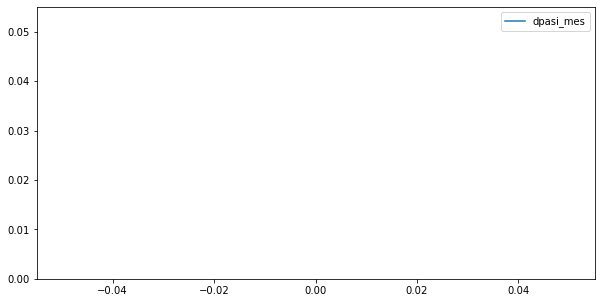

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5))
sns.kdeplot(df5["dpasi_mes"], shade=True,ax = ax);

In [30]:
df5

,id,ano,mes,dia,sexo_paciente,imc,bsa,dlqi,pga,depresion_total,...,endurecimiento_1,descamacion_1,pasi_1,fecha_dec,fecha_dec_1,meses_desde_consulta,dpasi,dpasi_mes,dpasi_porc_mes,pasi
0,20946751,2018,12,13,f,26.7,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,2019.035616,NaN,NaN,NaN,NaN,NaN,0.0
1,3499725,2013,5,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2013.422146,NaN,NaN,NaN,NaN,NaN,NaN
2,3499725,2013,7,29,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2013.662785,2013.422146,2.887671,NaN,NaN,NaN,NaN
3,3499725,2018,7,27,m,23.2,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,2018.657306,2013.662785,59.934247,NaN,NaN,NaN,0.4
4,3499725,2018,10,24,m,23.2,NaN,1.0,NaN,NaN,...,NaN,NaN,0.4,2018.899087,2018.657306,2.901370,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18403,501389,2020,2,28,f,24.6,NaN,9.0,NaN,0.0,...,NaN,NaN,2.7,2020.243379,2020.105251,1.657534,0.0,0.0,0.0,NaN
18404,501053,2019,3,4,f,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,2019.260959,NaN,NaN,NaN,NaN,NaN,0.0
18405,501053,2019,11,14,f,21.3,NaN,0.0,NaN,NaN,...,NaN,NaN,0.0,2019.955023,2019.260959,8.328767,0.0,0.0,NaN,0.0
18406,501053,2020,2,12,f,21.3,NaN,0.0,NaN,NaN,...,NaN,NaN,0.0,2020.199543,2019.955023,2.934247,0.0,0.0,NaN,NaN


In [31]:
df4["dpasi_mes"].describe()

count    11919.000000
mean        -0.509430
std          9.890708
min       -620.500000
25%          0.000000
50%          0.000000
75%          0.000000
max        149.041667
Name: dpasi_mes, dtype: float64

In [32]:
dpasi_f0 = ('dpasi_mes ~ pasi_1 + imc_1 + bsa_1 + dlqi_1 + pga_1 + edad_1 + '
            'depresion_total_1 + ansiedad_total_1 + trastorno_sexual_total_1 + psi_total_1 + '
            'eritema_1 + endurecimiento_1 + descamacion_1 + '
            'medicamento_adalimumab + medicamento_certolizumab + medicamento_etanercept + '
            'medicamento_golimumab + medicamento_guselkumab + medicamento_infliximab + '
            'medicamento_ixekinumab + medicamento_secukinumab  + medicamento_ustekinumab + '
            'medicamento_adalimumab*pasi_1 + medicamento_certolizumab*pasi_1 + medicamento_etanercept*pasi_1 + '
            'medicamento_golimumab*pasi_1 + medicamento_guselkumab*pasi_1 + medicamento_infliximab*pasi_1 + '
            'medicamento_ixekinumab*pasi_1 + medicamento_secukinumab*pasi_1  + medicamento_ustekinumab*pasi_1' 
           )
model_f0 = smf.ols(formula = dpasi_f0, data = df4.dropna()).fit()
model_f0.summary()


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dpasi_mes   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.120
Date:                Sat, 25 Jul 2020   Prob (F-statistic):           3.83e-05
Time:                        02:56:58   Log-Likelihood:                -12632.
No. Observations:                3118   AIC:                         2.535e+04
Df Residuals:                    3075   BIC:                         2.561e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  0.7627      1.465      0.521      0.603      -2.109       3.634
eritema_1[T.1.0]                          -1.0001      1.051     -0.951      0.342      -3.061       1.061
eritema_1[T.2.0]                          -0.6811      1.240     -0.549      0.583      -3.112       1.750
eritema_1[T.3.0]                           0.6037      1.464      0.412      0.680      -2.267       3.474
eritema_1[T.4.0]                           1.2860      1.902      0.676      0.499      -2.443       5.015
eritema_1[T.5.0]                           1.0649      4.195      0.254      0.800      -7.161       9.290
endurecimiento_1[T.1.0]                    2.5681      0.952      2.697      0.007       0.701       4.435
endurecimiento_1[T.2.0]                    3.9183      1.234      3.175      0.002       1.499       6.338
endurecimiento_1[T.3.0]                    5.5275      1.560      3.542      0.000       2.468       8.587
endurecimiento_1[T.4.0]                    4.0959      2.002      2.046      0.041       0.170       8.022
endurecimiento_1[T.5.0]                    4.8522      4.791      1.013      0.311      -4.542      14.247
descamacion_1[T.1.0]                      -0.7407      1.081     -0.685      0.493      -2.860       1.378
descamacion_1[T.2.0]                      -1.9905      1.331     -1.496      0.135      -4.600       0.619
descamacion_1[T.3.0]                      -3.3331      1.627     -2.048      0.041      -6.523      -0.143
descamacion_1[T.4.0]                      -2.2155      2.139     -1.036      0.300      -6.410       1.979
descamacion_1[T.5.0]                       1.7445      5.233      0.333      0.739      -8.516      12.005
medicamento_adalimumab[T.1.0]             -1.1723      1.135     -1.033      0.302      -3.398       1.053
medicamento_certolizumab[T.1.0]            0.9696      6.777      0.143      0.886     -12.319      14.258
medicamento_etanercept[T.1.0]             -0.2674      1.583     -0.169      0.866      -3.372       2.837
medicamento_golimumab[T.1.0]               0.2972      8.072      0.037      0.971     -15.530      16.125
medicamento_guselkumab[T.1.0]            -11.1756      4.388     -2.547      0.011     -19.780      -2.571
medicamento_infliximab[T.1.0]             -0.8844     14.042     -0.063      0.950     -28.416      26.648
medicamento_ixekinumab[T.1.0]             -1.6204      2.000     -0.810      0.418      -5.542       2.301
medicamento_secukinumab[T.1.0]            -0.5397      1.315     -0.410      0.682      -3.118       2.039
medicamento_ustekinumab[T.1.0]            -1.1702      1.079     -1.084      0.278      -3.287       0.946
pasi_1                                    -0.4302      0.091     -4.740      0.000     

In [33]:

dpasi_f1 = ('dpasi_mes ~ pasi_1 + imc_1 + bsa_1 + dlqi_1 + pga_1 + edad_1 + '
            'depresion_total_1 + ansiedad_total_1 + trastorno_sexual_total_1 + psi_total_1 + '
            'eritema_1 + endurecimiento_1 + descamacion_1 + '
            'medicamento_adalimumab + medicamento_certolizumab + medicamento_etanercept + '
            'medicamento_golimumab + medicamento_guselkumab + medicamento_infliximab + '
            'medicamento_ixekinumab + medicamento_secukinumab  + medicamento_ustekinumab + '
            'medicamento_adalimumab*pasi_1 + medicamento_certolizumab*pasi_1 + medicamento_etanercept*pasi_1 + '
            'medicamento_golimumab*pasi_1 + medicamento_guselkumab*pasi_1 + medicamento_infliximab*pasi_1 + '
            'medicamento_ixekinumab*pasi_1 + medicamento_secukinumab*pasi_1  + medicamento_ustekinumab*pasi_1' 
           )
model_f1 = smf.ols(formula = dpasi_f1, data = df5.dropna()).fit()
model_f1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dpasi_mes   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     2.305
Date:                Sat, 25 Jul 2020   Prob (F-statistic):           1.21e-05
Time:                        02:57:02   Log-Likelihood:                -3336.0
No. Observations:                 704   AIC:                             6756.
Df Residuals:                     662   BIC:                             6947.
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
==========================================================================================================
                                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  2.5158      5.981      0.421      0.674      -9.228      14.259
eritema_1[T.1.0]                          -2.9658      4.723     -0.628      0.530     -12.240       6.309
eritema_1[T.2.0]                          -0.4385      5.746     -0.076      0.939     -11.721      10.844
eritema_1[T.3.0]                           6.5339      7.130      0.916      0.360      -7.465      20.533
eritema_1[T.4.0]                          13.9118      9.508      1.463      0.144      -4.758      32.581
eritema_1[T.5.0]                          20.5331     15.252      1.346      0.179      -9.416      50.482
endurecimiento_1[T.1.0]                   10.9416      4.025      2.719      0.007       3.039      18.844
endurecimiento_1[T.2.0]                   19.0649      5.559      3.429      0.001       8.149      29.981
endurecimiento_1[T.3.0]                   25.3095      7.252      3.490      0.001      11.069      39.550
endurecimiento_1[T.4.0]                   21.5076      9.829      2.188      0.029       2.207      40.808
endurecimiento_1[T.5.0]                   24.1508     18.747      1.288      0.198     -12.661      60.962
descamacion_1[T.1.0]                       1.6368      4.784      0.342      0.732      -7.757      11.031
descamacion_1[T.2.0]                      -3.1332      6.242     -0.502      0.616     -15.389       9.123
descamacion_1[T.3.0]                     -11.2554      7.761     -1.450      0.147     -26.494       3.983
descamacion_1[T.4.0]                      -2.6797     10.176     -0.263      0.792     -22.662      17.302
descamacion_1[T.5.0]                       4.1064     21.863      0.188      0.851     -38.824      47.036
medicamento_adalimumab[T.1.0]             -4.6285      4.692     -0.987      0.324     -13.841       4.584
medicamento_certolizumab[T.1.0]           -0.4712     28.700     -0.016      0.987     -56.825      55.883
medicamento_etanercept[T.1.0]              1.1987      6.532      0.184      0.854     -11.626      14.024
medicamento_golimumab[T.1.0]              -2.0777     21.608     -0.096      0.923     -44.506      40.350
medicamento_guselkumab[T.1.0]            -78.3281     37.707     -2.077      0.038    -152.369      -4.288
medicamento_infliximab[T.1.0]             -2.2971     28.783     -0.080      0.936     -58.813      54.219
medicamento_ixekinumab[T.1.0]             -1.9316      7.592     -0.254      0.799     -16.838      12.975
medicamento_secukinumab[T.1.0]            -2.4803      4.963     -0.500      0.617     -12.226       7.265
medicamento_ustekinumab[T.1.0]            -2.4604      4.581     -0.537      0.591     -11.455       6.535
pasi_1                                    -1.4701      0.400     -3.673      0.000     

In [34]:

dpasi_f2 = ('dpasi_mes ~ pasi_1 + imc_1 + bsa_1 + dlqi_1 + pga_1 + edad_1 + '
            'depresion_total_1 + ansiedad_total_1 + trastorno_sexual_total_1 + psi_total_1 + '
            'eritema_1 + endurecimiento_1 + descamacion_1 + '
            'medicamento_adalimumab + medicamento_certolizumab + medicamento_etanercept + '
            'medicamento_golimumab + medicamento_guselkumab + medicamento_infliximab + '
            'medicamento_ixekinumab + medicamento_secukinumab  + medicamento_ustekinumab'
            )
model_f2 = smf.ols(formula = dpasi_f2, data = df5.dropna()).fit()
model_f2.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dpasi_mes   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     2.740
Date:                Sat, 25 Jul 2020   Prob (F-statistic):           1.02e-06
Time:                        02:57:04   Log-Likelihood:                -3338.4
No. Observations:                 704   AIC:                             6745.
Df Residuals:                     670   BIC:                             6900.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           1.1197      5.836      0.192      0.848     -10.340      12.579
eritema_1[T.1.0]                   -3.0217      4.702     -0.643      0.521     -12.255       6.211
eritema_1[T.2.0]                   -0.4279      5.707     -0.075      0.940     -11.634      10.778
eritema_1[T.3.0]                    6.4213      7.079      0.907      0.365      -7.478      20.321
eritema_1[T.4.0]                   15.3738      9.406      1.634      0.103      -3.095      33.842
eritema_1[T.5.0]                   24.9523     14.568      1.713      0.087      -3.652      53.557
endurecimiento_1[T.1.0]            11.1211      4.008      2.775      0.006       3.251      18.991
endurecimiento_1[T.2.0]            19.4533      5.533      3.516      0.000       8.589      30.317
endurecimiento_1[T.3.0]            24.9508      7.183      3.474      0.001      10.847      39.054
endurecimiento_1[T.4.0]            21.3745      9.755      2.191      0.029       2.221      40.528
endurecimiento_1[T.5.0]            28.0723     18.511      1.516      0.130      -8.275      64.420
descamacion_1[T.1.0]                2.0986      4.735      0.443      0.658      -7.199      11.396
descamacion_1[T.2.0]               -2.6642      6.168     -0.432      0.666     -14.775       9.447
descamacion_1[T.3.0]               -9.9671      7.660     -1.301      0.194     -25.008       5.074
descamacion_1[T.4.0]               -1.3127     10.080     -0.130      0.896     -21.104      18.479
descamacion_1[T.5.0]                0.2900     21.525      0.013      0.989     -41.975      42.555
medicamento_adalimumab[T.1.0]      -3.0868      3.881     -0.795      0.427     -10.708       4.534
medicamento_certolizumab[T.1.0]    -7.3243     16.747     -0.437      0.662     -40.206      25.558
medicamento_etanercept[T.1.0]       1.0075      4.971      0.203      0.839      -8.753      10.768
medicamento_golimumab[T.1.0]       -4.1035     16.638     -0.247      0.805     -36.772      28.565
medicamento_guselkumab[T.1.0]     -33.7904     16.632     -2.032      0.043     -66.447      -1.134
medicamento_infliximab[T.1.0]      -1.0527     28.691     -0.037      0.971     -57.387      55.281
medicamento_ixekinumab[T.1.0]       3.9224      6.115      0.641      0.521      -8.084      15.928
medicamento_secukinumab[T.1.0]      0.0195      3.659      0.005      0.996      -7.165       7.204
medicamento_ustekinumab[T.1.0]     -0.0804      3.807     -0.021      0.983      -7.555       7.394
pasi_1                             -1.2462      0.363     -3.436      0.001      -1.958      -0.534
imc_1                               0.0514      0.067      0.772      0.440      -0.079       0.182
bsa_1                              -0.2191      0.156     -1.403      0.161      -0

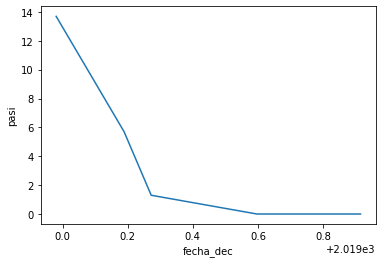

In [35]:
sns.lineplot(x = "fecha_dec",
             y = "pasi",
             data = df5[df5["id"]==ids[2]])

In [36]:
df5

,id,ano,mes,dia,sexo_paciente,imc,bsa,dlqi,pga,depresion_total,...,endurecimiento_1,descamacion_1,pasi_1,fecha_dec,fecha_dec_1,meses_desde_consulta,dpasi,dpasi_mes,dpasi_porc_mes,pasi
0,20946751,2018,12,13,f,26.7,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,2019.035616,NaN,NaN,NaN,NaN,NaN,0.0
1,3499725,2013,5,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2013.422146,NaN,NaN,NaN,NaN,NaN,NaN
2,3499725,2013,7,29,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2013.662785,2013.422146,2.887671,NaN,NaN,NaN,NaN
3,3499725,2018,7,27,m,23.2,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,2018.657306,2013.662785,59.934247,NaN,NaN,NaN,0.4
4,3499725,2018,10,24,m,23.2,NaN,1.0,NaN,NaN,...,NaN,NaN,0.4,2018.899087,2018.657306,2.901370,0.0,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18403,501389,2020,2,28,f,24.6,NaN,9.0,NaN,0.0,...,NaN,NaN,2.7,2020.243379,2020.105251,1.657534,0.0,0.0,0.0,NaN
18404,501053,2019,3,4,f,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,2019.260959,NaN,NaN,NaN,NaN,NaN,0.0
18405,501053,2019,11,14,f,21.3,NaN,0.0,NaN,NaN,...,NaN,NaN,0.0,2019.955023,2019.260959,8.328767,0.0,0.0,NaN,0.0
18406,501053,2020,2,12,f,21.3,NaN,0.0,NaN,NaN,...,NaN,NaN,0.0,2020.199543,2019.955023,2.934247,0.0,0.0,NaN,NaN


In [42]:
df5.shape

(18408, 58)

In [43]:
df4.shape

(18408, 60)

In [44]:
df5.dropna().shape

(704, 58)

In [45]:
df4.dropna().shape

(3118, 60)